# Import and setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
# import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [3]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

traj = EMRIInspiral(func=KerrEccEqFlux)
amp = AmpInterpKerrEccEq() # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum()
ylm_gen = GetYlms(include_minus_m=False)




# Generate waveform

In [5]:
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt)

# t_gpu = cp.asarray(t)

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

In [6]:
teuk_modes.shape

(11, 6993)

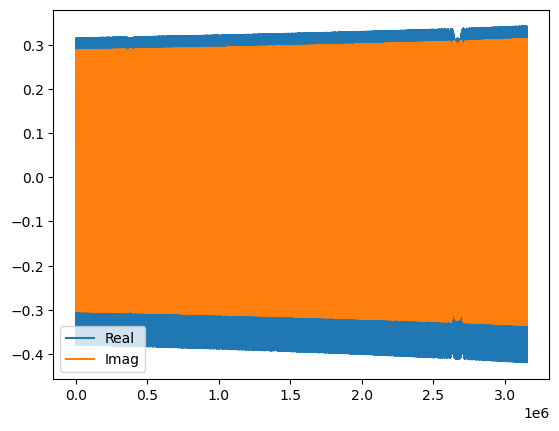

In [7]:
# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

# perform summation
waveform1 = interpolate_mode_sum(
    t,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

plt.plot(waveform1.real, label="Real")
plt.plot(waveform1.imag, label="Imag")
plt.legend(loc="lower left")

In [9]:
N = int(len(waveform1)) 
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)
# Calculate distance dimensionless
dist = 1.0 #Gpc
factor = gwf.dist_factor(dist, m2)
waveform1_scaled = waveform1/factor

In [10]:
hfull_f = gwf.freq_wave(waveform1_scaled)

SNR_ref = gwf.SNR(hfull_f)
print("SNR:", SNR_ref)
print("SNR squared:", SNR_ref**2)

SNR: 38.19708598849489
SNR squared: 1459.0173780124728


In [14]:
# Convert T to standard units
T_sd = 1.0 * YRSID_SI  # 1 sidereal year in seconds (~31,558,150 seconds)
print("Observation time in seconds:", T_sd)

Observation time in seconds: 31558149.763545595


In [15]:
N_traj = teuk_modes.shape[0]  # number of trajectory points
print("Number of trajectory points:", N_traj)
delta_T = T_sd / N_traj  # time step in seconds
print("Time step in seconds", delta_T)

Number of trajectory points: 11
Time step in seconds 2868922.705776872


In [16]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

# Generate mode frequencies 

Using *get_fundamental_frequencies* instead

In [17]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)

In [18]:
OmegaPhi

array([0.03205396, 0.03205724, 0.03206807, 0.03209582, 0.03218097,
       0.03250499, 0.03423571, 0.03588402, 0.03758724, 0.0393431 ,
       0.04003604])

In [19]:
gw_frequencies_per_mode = []
mode_frequencies = {}

for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [20]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Calculate inner product

In [21]:
idx_i = 1165 # 220
idx_j = 1166 # 221
mode_labels[idx_i], mode_labels[idx_j]

('(2,2,0)', '(2,2,1)')

In [22]:
# Get complex amplitudes for the two modes
A0 = teuk_modes[:, idx_i]
A1 = teuk_modes[:, idx_j]
print("A_0:", A0)
print("A_1:", A1)

A_0: [0.44924664-0.12386828j 0.44928771-0.12388589j 0.44942348-0.12394409j
 0.44977097-0.1240931j  0.45083585-0.12455013j 0.45487033-0.12628676j
 0.47595481-0.13548793j 0.49535239-0.14412215j 0.51475619-0.15289684j
 0.53413799-0.1617726j  0.54162553-0.16522501j]
A_1: [0.26093475-0.08208452j 0.26093606-0.0820878j  0.26094042-0.08209865j
 0.26095151-0.08212639j 0.26098504-0.08221107j 0.26110611-0.08252764j
 0.26160121-0.08407366j 0.26189359-0.08534002j 0.26208225-0.08646406j
 0.26221704-0.08745186j 0.26226515-0.08779906j]


In [23]:
# Get sensitivity for the two modes
Sn0 = get_sensitivity(gw_frequencies_per_mode[idx_i], sens_fn=LISASens, return_type="PSD")
Sn1 = get_sensitivity(gw_frequencies_per_mode[idx_j], sens_fn=LISASens, return_type="PSD")

In [24]:
barA0 = A0 / np.sqrt(Sn0)
barA0 

array([1.02549867e+19-2.82755056e+18j, 1.02550100e+19-2.82770033e+18j,
       1.02550863e+19-2.82819530e+18j, 1.02552777e+19-2.82946062e+18j,
       1.02558279e+19-2.83332546e+18j, 1.02574206e+19-2.84779262e+18j,
       1.02537106e+19-2.91887791e+18j, 1.02339903e+19-2.97756661e+18j,
       1.02005202e+19-3.02983696e+18j, 1.01551110e+19-3.07564473e+18j,
       1.01347124e+19-3.09163413e+18j])

In [25]:
barA1 = A1 / np.sqrt(Sn1)
barA1

array([4.53923442e+18-1.42794654e+18j, 4.53885817e+18-1.42787808e+18j,
       4.53761442e+18-1.42765169e+18j, 4.53443248e+18-1.42707190e+18j,
       4.52469170e+18-1.42529149e+18j, 4.48793222e+18-1.41849782e+18j,
       4.29984663e+18-1.38188909e+18j, 4.13340338e+18-1.34690089e+18j,
       3.97391910e+18-1.31104330e+18j, 3.82214812e+18-1.27472254e+18j,
       3.76562026e+18-1.26062466e+18j])

In [26]:
phase01 = np.abs(gw_phase_per_mode[idx_i] - gw_phase_per_mode[idx_j]) < 1.0 
phase01

array([ True, False, False, False, False, False, False, False, False,
       False, False])

In [27]:
crossprod01 = np.conj(barA0[phase01]) * barA1[phase01]
crossprod01

array([5.05873796e+37-1.80865793e+36j])

In [28]:
inner_contrib_01 = np.sum(crossprod01) * delta_T * 1/(factor**2)
np.real(inner_contrib_01)

np.float64(33.23536183686824)

In [29]:
selfprod00 = np.conj(barA0)*barA0 
selfprod00

array([1.13159794e+38-1.62405645e+21j, 1.13161119e+38+8.58996633e+20j,
       1.13165485e+38+1.99484797e+21j, 1.13176569e+38+9.86592002e+19j,
       1.13209740e+38-6.76756502e+20j, 1.13324600e+38-1.15680795e+21j,
       1.13658429e+38+1.89237898e+21j, 1.13600461e+38+8.24669161e+19j,
       1.13230525e+38-7.37369658e+20j, 1.12585871e+38+2.20434319e+21j,
       1.12270597e+38-3.56575416e+20j])

In [30]:
inner_contrib_00 = np.sum(selfprod00) * delta_T * 1/(factor**2)
np.real(inner_contrib_00)

np.float64(817.6514286452215)

In [31]:
np.real(np.sum(barA0**2) * delta_T * 1/(factor**2))

np.float64(694.509869340131)

In [32]:
np.real(np.sum(np.conj(barA1)*barA1) * delta_T * 1/(factor**2))

np.float64(147.1515164132481)

In [33]:
np.real(np.sum(barA1**2) * delta_T * 1/(factor**2))

np.float64(119.75129754237759)

# Reference values

In [34]:
indices = [1165, 1166]

In [36]:
waveform_per_mode = []
for idx in indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], 
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)

Mode:  (2,2,0)
Mode:  (2,2,1)


In [37]:
# Convert each waveform to frequency domain
hf_per_mode = [gwf.freq_wave(waveform) for waveform in waveform_per_mode]

In [38]:
gwf.inner(hf_per_mode[0], hf_per_mode[1])

np.float64(-0.0051385368643973505)

In [39]:
gwf.inner(hf_per_mode[0], hf_per_mode[0])

np.float64(585.780453906222)

In [40]:
gwf.inner(hf_per_mode[1], hf_per_mode[1])

np.float64(466.6164564228653)